In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [2]:
np.random.seed(1)

In [3]:
data = pd.read_csv("Public_Data_2.csv")
data = data.iloc[:,1:] #Remove Unique ID
data

,BlueScore,GreenScore,OrangeScore,PurpleScore,WhiteScore,YellowScore,Blue1,Blue2,Blue3,Blue4,...,Yellow25,Yellow26,Yellow27,Yellow28,TotalAttempts,AvgCorrectPerSession,AvgAttemptsPerSession,AvgSecondsPerSession,TotalSessions,CertScore
0,0.000000,0.000000,0.000000,0.00,1.00,0.000000,0,0,0,0,...,0,0,0,0,40,12.50,20.00,3558,2,62.6
1,0.000000,0.750000,0.800000,0.00,1.00,1.000000,0,0,0,0,...,1,1,1,1,258,18.40,51.60,5288,5,81.0
2,0.000000,0.500000,0.200000,0.00,0.20,0.821429,0,0,0,0,...,1,0,1,0,99,6.12,12.38,1657,8,77.2
3,0.000000,0.222222,0.400000,0.00,0.00,1.000000,0,0,0,0,...,1,1,1,1,446,5.25,55.75,4166,8,73.0
4,0.944444,0.888889,0.800000,0.00,1.00,0.964286,1,1,1,1,...,1,1,1,0,396,12.56,44.00,7882,9,54.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,1.000000,0.972222,1.000000,1.00,1.00,1.000000,1,1,1,1,...,1,1,1,1,568,2.25,8.74,1834,69,90.0
204,1.000000,0.972222,1.000000,0.96,0.68,1.000000,1,1,1,1,...,1,1,1,1,659,2.01,9.69,1524,71,75.9
205,0.944444,0.944444,0.533333,0.84,0.84,1.000000,1,1,1,1,...,1,1,1,1,1223,1.79,16.99,2743,74,49.4
206,0.944444,0.972222,1.000000,1.00,1.00,0.928571,1,1,1,1,...,1,1,1,0,795,2.23,12.42,1402,85,90.1


In [4]:
sample_indices = np.random.choice(range(len(data)), size=round(0.8 * len(data)), replace=False) #Creates 80-20 split
train = data.iloc[sample_indices,]
test = data.drop(sample_indices)

In [5]:
train = train.reset_index(drop=True)
len(train)

166

In [6]:
test = test.reset_index(drop=True)
len(test)

42

In [7]:
X_train = np.array(train.iloc[:,:158])
y_train = np.array(train.iloc[:,158])
X_test = np.array(test.iloc[:,:158])
y_test = np.array(test.iloc[:,158])

In [8]:
non_one_hot_indices = [0, 1, 2, 3, 4, 5, -1, -2, -3, -4, -5]

In [9]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def normalize(X_train, X_test):
    
    scaler = StandardScaler()
    
    non_one_hot_data = X_train[:,non_one_hot_indices]
    normalized_data = scaler.fit_transform(non_one_hot_data)
    X_train[:,non_one_hot_indices] = normalized_data
    
    non_one_hot_data = X_test[:,non_one_hot_indices]
    normalized_data = scaler.transform(non_one_hot_data)
    X_test[:,non_one_hot_indices] = normalized_data
    
    return X_train, X_test

def compute_PCA(X_train, X_test):
    
    pca = PCA()
    X_train = pca.fit_transform(X_train)
    
    total_expl_var = np.cumsum(pca.explained_variance_)
    for ind, var in enumerate(total_expl_var):
        n_comp = ind
        if total_expl_var[ind + 1] - var < 0.1:
            n_comp += 1
            break
            
    X_train = X_train[:,:n_comp]
    
    X_test = pca.transform(X_test)
    X_test = X_test[:,:n_comp]
    
    return X_train, X_test

def cross_validate_model(model, X, y, df=False):
    
    kf = KFold(n_splits=5, random_state=None, shuffle=False)
    
    rmses = []
    maes = []
    
    for train_index, test_index in kf.split(X):
        
        cv_X_train = X[train_index]
        cv_y_train = y[train_index]
        
        cv_X_test = X[test_index]
        cv_y_test = y[test_index]
        
        cv_X_train, cv_X_test = normalize(cv_X_train, cv_X_test)
        cv_X_train, cv_X_test = compute_PCA(cv_X_train, cv_X_test)
        
        if df:
            cv_X_train = pd.DataFrame(cv_X_train)
            cv_X_test = pd.DataFrame(cv_X_test)
        
        cv_model = model.fit(cv_X_train, cv_y_train)
        
        cv_preds = cv_model.predict(cv_X_test)
        
        cv_mse = np.mean((cv_preds - cv_y_test) ** 2)
        cv_rmse = np.sqrt(cv_mse)
        cv_mae = np.mean(np.abs(cv_preds - cv_y_test))
        
        rmses.append(cv_rmse)
        maes.append(cv_mae)
        
    rmse = np.mean(rmses)
    mae = np.mean(maes)
    
    return rmse, mae  

In [10]:
def cross_validate_logit_model(model, X, y, df=False):
    
    kf = KFold(n_splits=5, random_state=None, shuffle=False)
    
    rmses = []
    maes = []
    
    for train_index, test_index in kf.split(X):
        
        cv_X_train = X[train_index]
        cv_y_train = y[train_index]
        
        cv_y_train = cv_y_train / 100
        cv_y_train = np.log(cv_y_train / (1 - cv_y_train))
        
        cv_X_test = X[test_index]
        cv_y_test = y[test_index]
        
        cv_X_train, cv_X_test = normalize(cv_X_train, cv_X_test)
        
        if df:
            cv_X_train = pd.DataFrame(cv_X_train)
            cv_X_test = pd.DataFrame(cv_X_test)
        
        cv_model = model.fit(cv_X_train, cv_y_train)
        
        cv_preds = cv_model.predict(cv_X_test)
        cv_preds = np.exp(cv_preds) / (1 + np.exp(cv_preds))
        cv_preds = cv_preds * 100
        
        cv_mse = np.mean((cv_preds - cv_y_test) ** 2)
        cv_rmse = np.sqrt(cv_mse)
        cv_mae = np.mean(np.abs(cv_preds - cv_y_test))
        
        rmses.append(cv_rmse)
        maes.append(cv_mae)
        
    rmse = np.mean(rmses)
    mae = np.mean(maes)
    
    return rmse, mae 

In [11]:
X_train_holdout_norm, X_test_holdout_norm = normalize(X_train, X_test)
X_train_holdout_PCA, X_test_holdout_PCA = compute_PCA(X_train_holdout_norm, X_test_holdout_norm)

In [12]:
y_train_holdout = y_train / 100
y_train_holdout = np.log(y_train_holdout / (1 - y_train_holdout))

In [13]:
from sklearn.linear_model import Ridge

learning_rate = [i for i in range(1, 101)]

Ridge_data = {"lr": [], "rmse": [], "mae": []}

for lr in learning_rate:
    
    model = Ridge(alpha=lr, random_state=22)
    
    rmse, mae = cross_validate_logit_model(model, X_train, y_train)
            
    Ridge_data["lr"].append(lr)
    Ridge_data["rmse"].append(rmse)
    Ridge_data["mae"].append(mae)

In [14]:
Ridge_data = pd.DataFrame(Ridge_data).sort_values(by='rmse').head(20).reset_index(drop=True)
Ridge_data

,lr,rmse,mae
0,16,10.852533,8.081771
1,17,10.853239,8.086224
2,15,10.853360,8.080611
3,18,10.855193,8.090880
4,14,10.856083,8.083367
5,19,10.858168,8.096002
6,13,10.861171,8.086575
7,20,10.861981,8.101016
8,21,10.866483,8.105922
9,12,10.869237,8.090148


In [15]:
model = Ridge(alpha=Ridge_data["lr"][0], random_state=22)
model.fit(X_train_holdout_norm, y_train_holdout)
preds = model.predict(X_test_holdout_norm)
preds = np.exp(preds) / (1 + np.exp(preds))
preds = preds * 100
mae = np.mean(np.abs(preds - y_test))
rmse = np.sqrt(np.mean((preds - y_test) ** 2))

print("The mae on the holdout is:", mae, "\n")
print("The rmse on the holdout is:", rmse)

The mae on the holdout is: 7.948305156462233 

The rmse on the holdout is: 10.455041672451094


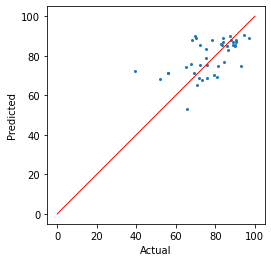

<Figure size 864x864 with 0 Axes>

In [16]:
plt.scatter(y_test, preds, s=4)
plt.plot(np.linspace(0, 100, 1000), np.linspace(0, 100, 1000), color='red', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.figure(figsize=(12,12))
plt.draw()

In [17]:
from sklearn.linear_model import Lasso

learning_rate = np.arange(0.001, 0.02, 0.0001)

Lasso_data = {"lr": [], "rmse": [], "mae": []}

for lr in learning_rate:
    
    model = Lasso(alpha=lr, random_state=22, max_iter=100000)
    
    rmse, mae = cross_validate_logit_model(model, X_train, y_train)
            
    Lasso_data["lr"].append(lr)
    Lasso_data["rmse"].append(rmse)
    Lasso_data["mae"].append(mae)

In [18]:
Lasso_data = pd.DataFrame(Lasso_data).sort_values(by='rmse').head(20).reset_index(drop=True)
Lasso_data

,lr,rmse,mae
0,0.0175,10.692442,7.995136
1,0.0176,10.692458,7.995780
2,0.0177,10.692829,7.996662
3,0.0174,10.693020,7.994971
4,0.0178,10.693125,7.997428
5,0.0179,10.693379,7.998042
6,0.0180,10.693632,7.998634
7,0.0173,10.693753,7.994895
8,0.0181,10.694101,7.999379
9,0.0182,10.694580,8.000117


In [19]:
model = Lasso(alpha=Lasso_data["lr"][0], random_state=22, max_iter=100000)
model.fit(X_train_holdout_norm, y_train_holdout)
preds = model.predict(X_test_holdout_norm)
preds = np.exp(preds) / (1 + np.exp(preds))
preds = preds * 100
mae = np.mean(np.abs(preds - y_test))
rmse = np.sqrt(np.mean((preds - y_test) ** 2))

print("The mae on the holdout is:", mae, "\n")
print("The rmse on the holdout is:", rmse)

The mae on the holdout is: 7.722187734664503 

The rmse on the holdout is: 10.305885866425138


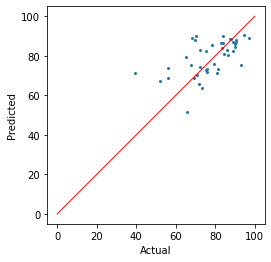

<Figure size 864x864 with 0 Axes>

In [20]:
plt.scatter(y_test, preds, s=4)
plt.plot(np.linspace(0, 100, 1000), np.linspace(0, 100, 1000), color='red', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.figure(figsize=(12,12))
plt.draw()

In [21]:
from sklearn.ensemble import RandomForestRegressor as RF

n_estimators = range(1, 21)
max_depth = range(1, 21)
max_features = np.arange(0.1, 1.1, 0.1)

RF_data = {"n": [], "d": [], "f": [], "rmse": [], 'mae': []}

for n in n_estimators:
    for d in max_depth:
        for f in max_features:
            
            model = RF(n_estimators=n, max_depth=d, max_features=f, random_state=22)
            
            rmse, mae = cross_validate_model(model, X_train, y_train)
            
            RF_data["n"].append(n)
            RF_data["d"].append(d)
            RF_data["f"].append(f)
            RF_data["rmse"].append(rmse)
            RF_data["mae"].append(mae)

In [22]:
RF_data = pd.DataFrame(RF_data).sort_values(by='rmse').head(20).reset_index(drop=True)
RF_data

,n,d,f,rmse,mae
0,6,5,0.7,10.352977,8.087366
1,7,5,0.7,10.370885,8.157207
2,9,5,0.7,10.555071,8.217772
3,8,5,0.7,10.588837,8.231202
4,10,5,0.7,10.643876,8.268425
5,13,11,0.7,10.651451,8.158314
6,14,11,0.7,10.655151,8.178355
7,5,5,0.7,10.668530,8.327194
8,13,5,0.7,10.676676,8.235344
9,12,5,0.7,10.682307,8.221078


In [23]:
model = RF(n_estimators=RF_data["n"][0], max_depth=RF_data["d"][0], max_features=RF_data["f"][0], random_state=22)
model.fit(X_train_holdout_PCA, y_train)
preds = model.predict(X_test_holdout_PCA)
mae = np.mean(np.abs(preds - y_test))
rmse = np.sqrt(np.mean((preds - y_test) ** 2))

print("The mae on the holdout is:", mae, "\n")
print("The rmse on the holdout is:", rmse)

The mae on the holdout is: 7.750754987661791 

The rmse on the holdout is: 10.453801834679858


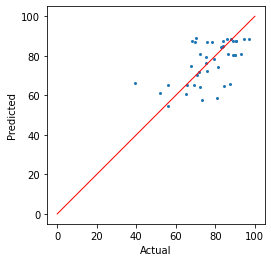

<Figure size 864x864 with 0 Axes>

In [24]:
plt.scatter(y_test, preds, s=4)
plt.plot(np.linspace(0, 100, 1000), np.linspace(0, 100, 1000), color='red', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.figure(figsize=(12,12))
plt.draw()

In [25]:
from sklearn.ensemble import BaggingRegressor as BR

n_estimators = range(1, 21)
max_samples = np.arange(0.1, 1.1, 0.1)
max_features = np.arange(0.1, 1.1, 0.1)

BR_data = {"n": [], "s": [], "f": [], "rmse": [], 'mae': []}

for n in n_estimators:
    for s in max_samples:
        for f in max_features:
            
            model = BR(n_estimators=n, max_samples=s, max_features=f, random_state=22)
            
            rmse, mae = cross_validate_model(model, X_train, y_train)
            
            BR_data["n"].append(n)
            BR_data["s"].append(s)
            BR_data["f"].append(f)
            BR_data["rmse"].append(rmse)
            BR_data["mae"].append(mae)

In [26]:
BR_data = pd.DataFrame(BR_data).sort_values(by='rmse').head(20).reset_index(drop=True)
BR_data

,n,s,f,rmse,mae
0,12,1.0,0.9,10.935694,8.350258
1,15,1.0,0.9,10.946792,8.322044
2,14,1.0,0.9,10.954256,8.363770
3,16,1.0,0.9,10.970796,8.352112
4,17,1.0,0.9,10.974714,8.368847
5,11,1.0,0.9,10.975457,8.433999
6,20,1.0,0.9,10.986478,8.445721
7,13,1.0,0.9,11.000050,8.394724
8,16,0.5,0.7,11.001199,8.522240
9,17,1.0,0.8,11.008199,8.418498


In [27]:
model = BR(n_estimators=BR_data['n'][0], max_samples=BR_data['s'][0], max_features=BR_data['f'][0], random_state=22)
model.fit(X_train_holdout_PCA, y_train)
preds = model.predict(X_test_holdout_PCA)
mae = np.mean(np.abs(preds - y_test))
rmse = np.sqrt(np.mean((preds - y_test) ** 2))

print("The mae on the holdout is:", mae, "\n")
print("The rmse on the holdout is:", rmse)

The mae on the holdout is: 9.032579365079366 

The rmse on the holdout is: 11.462379929035947


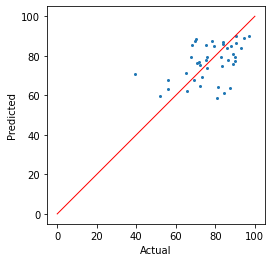

<Figure size 864x864 with 0 Axes>

In [28]:
plt.scatter(y_test, preds, s=4)
plt.plot(np.linspace(0, 100, 1000), np.linspace(0, 100, 1000), color='red', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.figure(figsize=(12,12))
plt.draw()

In [29]:
from sklearn.ensemble import AdaBoostRegressor as AB
from sklearn.tree import DecisionTreeRegressor as DT

n_estimators = range(1, 21)
max_depth = range(1, 21)
max_features = np.arange(0.1, 1.1, 0.1)
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 1.0, 10.0, 100.0]
loss = ['linear', 'square', 'exponential']

AB_data = {"n": [], "d": [], "f": [], "lr": [], "l": [], "rmse": [], 'mae': []}

for n in n_estimators:
    for lr in learning_rate:
        for l in loss:
            for d in max_depth:
                for f in max_features:
                
                    estimator = DT(max_depth=d, max_features=f, random_state=22)

                    model = AB(estimator=estimator,n_estimators=n, learning_rate=lr, loss=l, random_state=22)

                    rmse, mae = cross_validate_model(model, X_train, y_train)

                    AB_data["n"].append(n)
                    AB_data["d"].append(d)
                    AB_data["f"].append(f)
                    AB_data["lr"].append(lr)
                    AB_data["l"].append(l)
                    AB_data["rmse"].append(rmse)
                    AB_data["mae"].append(mae)

In [30]:
AB_data = pd.DataFrame(AB_data).sort_values(by='rmse').head(20).reset_index(drop=True)
AB_data

,n,d,f,lr,l,rmse,mae
0,16,15,0.3,1.00,linear,10.544615,7.852210
1,18,15,0.3,1.00,linear,10.592769,7.918163
2,19,12,0.2,0.30,square,10.625719,7.932992
3,16,11,0.2,0.20,exponential,10.635616,7.931704
4,6,4,0.5,0.30,exponential,10.651534,8.180781
5,19,5,0.2,1.00,linear,10.669712,8.102669
6,18,7,0.5,0.20,exponential,10.694777,7.970345
7,20,12,0.5,0.20,square,10.704561,8.329744
8,18,8,0.2,1.00,linear,10.710779,8.384995
9,18,5,0.1,1.00,square,10.715781,8.333051


In [31]:
estimator = DT(max_depth=AB_data["d"][0], max_features=AB_data["f"][0], random_state=22)
model = AB(base_estimator=estimator,n_estimators=AB_data["n"][0], learning_rate=AB_data["lr"][0], 
           loss=AB_data["l"][0], random_state=22)
model.fit(X_train_holdout_PCA, y_train)
preds = model.predict(X_test_holdout_PCA)
mae = np.mean(np.abs(preds - y_test))
rmse = np.sqrt(np.mean((preds - y_test) ** 2))

print("The mae on the holdout is:", mae, "\n")
print("The rmse on the holdout is:", rmse)

The mae on the holdout is: 8.007142857142858 

The rmse on the holdout is: 10.873613759485677


/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


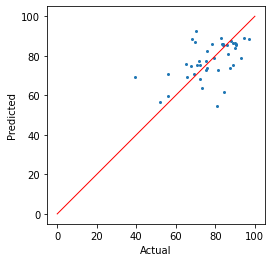

<Figure size 864x864 with 0 Axes>

In [32]:
plt.scatter(y_test, preds, s=4)
plt.plot(np.linspace(0, 100, 1000), np.linspace(0, 100, 1000), color='red', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.figure(figsize=(12,12))
plt.draw()